# Исследование поведения пользователей сервиса аренды самокатов

**Цель :** проанализировать данные и проверить  гипотезы, которые могут помочь бизнесу по аренде самокатов вырасти.

*Гипотезы:*
* Пользователи с подпиской тратят больше времени на поездки.
* Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 м.
* Помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки.
* Количество обращений в техподдержку значимо снизилось, так как техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. 

**Входные данные** —  3 CSV-файла  с данными, в которых есть информация о пользователях, их поездках и подписках.

**План:**

* Обзор данных.
* Предобработка данных.
* Исследовательский анализ данных.
* Объединение данных.
* Подсчёт выручки.
* Проверка гипотез.

## Загрузка данных

**Откроем файл с данными и изучим общую информацию**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')


In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:** В датафреймах описана информация о пользователях, их поездках и подписках.

## Предобработка данных

### Типы данных

Поменяем тип данных там, где это возможно

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
#приведем столбец date из датафрейма rides к типу даты
rides['date'] = pd.to_datetime(rides['date'], format ='%Y-%m-%d')

In [9]:
#создадим столбец month c данными о месяце поездки
rides['month'] = rides['date'].dt.month 

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [11]:
rides.tail()

,user_id,distance,duration,date,month
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11
18067,1534,2371.711192,15.893917,2021-12-29,12


In [12]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


### Дубликаты

Найдем пустые значения и дубликаты

**Изучим таблицу users**

In [13]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
users.duplicated().sum()

31

In [15]:
users = users.drop_duplicates() 


В таблице users не было пустых строк, а вот дубликаты 31 штука присутствовали. Мы их удалили

**Изучим таблицу rides**

In [16]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [17]:
rides.duplicated().sum()

0

В таблице rides нет пустых строк и явных дубликатов

**Изучим таблицу subscriptions**

In [18]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [19]:
subscriptions.duplicated().sum()

0

В таблице subscriptions нет пустых строк и отсутствуют явные дубликаты

**Вывод:**
Пропущенных данных в таблицах нет.

Дубликаты имеются среди пользователей и их 31, мы их удалили.

В таблице с информацией о поездках и подписках дубликатов нет.

Приобразовали столбец с датой в таблице rides в тип даты. Добавили в таблицу rides столбец month с номер месяца.

## Исследовательский анализ данных

Визуализируем часть данных

**Частота встречаемости городов**


In [20]:
city_stat = round(users.groupby('city')['user_id'].count()/users['city'].count()*100)

In [21]:
city_stat = users.groupby('city')['user_id'].count()
city_stat

city
Екатеринбург      204
Краснодар         193
Москва            168
Омск              183
Пятигорск         219
Ростов-на-Дону    198
Сочи              189
Тюмень            180
Name: user_id, dtype: int64

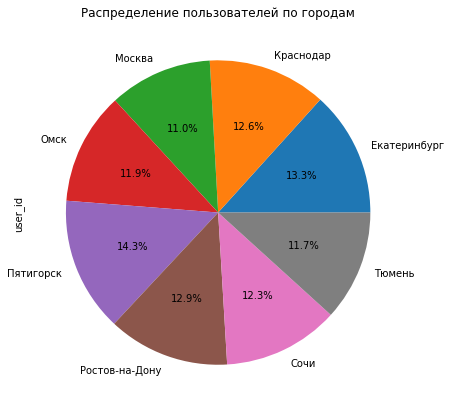

In [22]:
city_stat = users.groupby('city')['user_id'].count()
city_stat.plot(kind='pie', autopct='%1.1f%%', figsize=(12,7))
plt.title('Распределение пользователей по городам')
plt.show()

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьюера v1:</b> 
<br>Так как у нас группы с очень близкими результатами, то для визуализации больше подойдет барплот
</div>

**Cоотношение пользователей с подпиской и без подписк**

In [23]:
subscription_stat = users['subscription_type'].value_counts()

In [24]:
subscription_stat

free     835
ultra    699
Name: subscription_type, dtype: int64

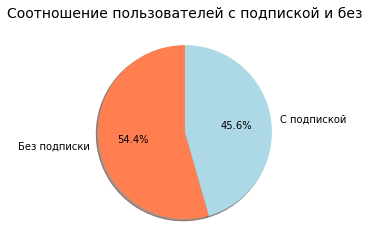

In [25]:
colors = ['coral', 'lightblue']
labels = 'Без подписки', 'С подпиской'
plt.pie(subscription_stat, labels = labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Соотношение пользователей с подпиской и без', fontsize=14)
plt.show()

**Возраст пользователей**

In [26]:
users['age'].value_counts().sort_index()

12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
Name: age, dtype: int64

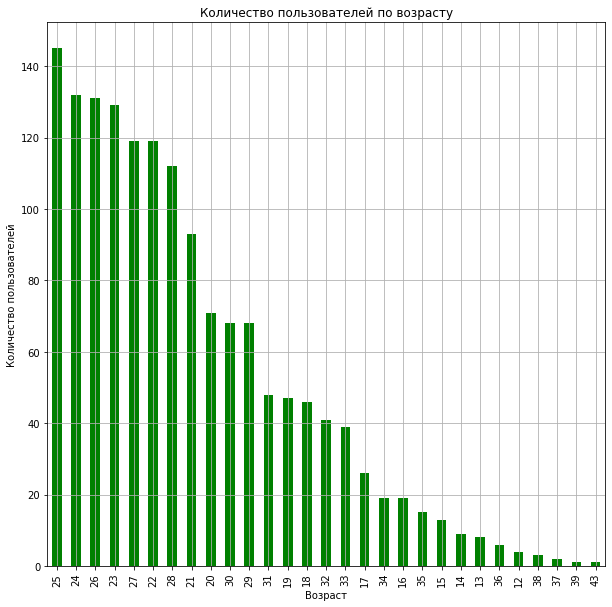

In [27]:
(
    users['age']
    .value_counts()
    .plot.bar(
        title='Количество пользователей по возрасту', color='green', xlabel='Возраст',
        ylabel='Количество пользователей', figsize=(10,10), grid=True
    )
)
plt.show()

**Расстояние, которое пользователь преодолел за одну поездку**

In [28]:
round(rides['distance'].agg(['mean', 'median','min','max']),2)

mean      3070.66
median    3133.61
min          0.86
max       7211.01
Name: distance, dtype: float64

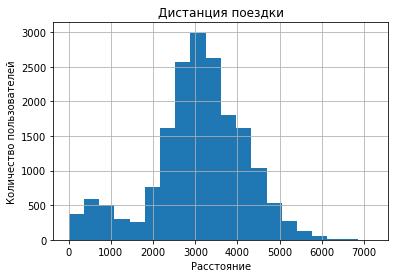

In [29]:
rides.hist(column = 'distance',bins=20)
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')
plt.title('Дистанция поездки')
plt.show()

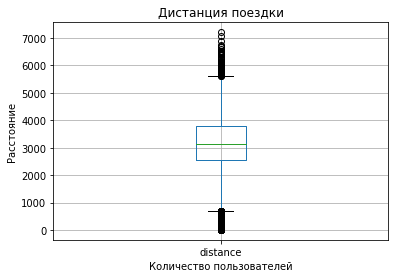

In [30]:
rides.boxplot(['distance'])
plt.xlabel('Количество пользователей')
plt.ylabel('Расстояние')
plt.title('Дистанция поездки')
plt.show()

**Продолжительность поездок**

In [31]:
round(rides['duration'].agg(['mean', 'median','min','max']),2)

mean      17.81
median    17.68
min        0.50
max       40.82
Name: duration, dtype: float64

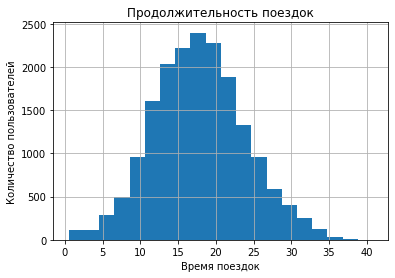

In [32]:
rides.hist(column='duration',bins=20)
plt.xlabel('Время поездок')
plt.ylabel('Количество пользователей')
plt.title('Продолжительность поездок')
plt.show()

**Вывод**

**Частота встречаемости городов:** пользоветели арендой самокатов распределены равномерно по всем городам

**Соотношение пользователей с подпиской и без подписки:** пользователей, которые используют бесплатную подписку больше и их 835 человека. 54.4% пользователей без подписок и 45.6 с подпиской.

**Возраст пользователей:** распределен от 12 до 43 лет. Наиболее активные пользователи от 20-30 лет.

**Расстояние, которое пользователь преодолел за одну поездку:** в среднем 3 км. Минимальное растояние - 0.86 км. Самая длинная - 7.2 км.

**Продолжительность поездок:** в среднем 17.68 минут. Минимальное время 50 секунд.Скорее всего или самокат был сломан или пользватель передумал пользоваться. Максимальное время поездки 40 минут.



**Объединим все таблицы в одну**

In [33]:
rides['user_id'].isna().sum()

0

In [34]:
users.shape[0], rides.shape[0]

(1534, 18068)

In [35]:
table = users.merge(rides, on='user_id', how ='left')
table.shape[0]

18068

In [36]:
table_users = table.merge(subscriptions, on='subscription_type',how = 'left')

In [37]:
table_users.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


**Создадим отдельные таблицы пользователей с подписками и без подписок**

In [38]:
users_without_subscriptions = table_users[table_users['subscription_type'] == 'free']

In [39]:
users_without_subscriptions.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [40]:
users_with_subscriptions = table_users[table_users['subscription_type'] == 'ultra']

In [41]:
users_with_subscriptions.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [42]:
users_with_subscriptions.shape

(6500, 12)

In [43]:
users_without_subscriptions.shape

(11568, 12)

**Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий**

In [44]:
users_without_subscriptions['distance'].agg(['mean', 'median','min','max'])

mean      3045.495282
median    3114.648465
min          0.855683
max       7211.007745
Name: distance, dtype: float64

In [45]:
users_with_subscriptions['distance'].agg(['mean', 'median','min','max'])

mean      3115.445388
median    3148.637229
min        244.210438
max       5699.769662
Name: distance, dtype: float64

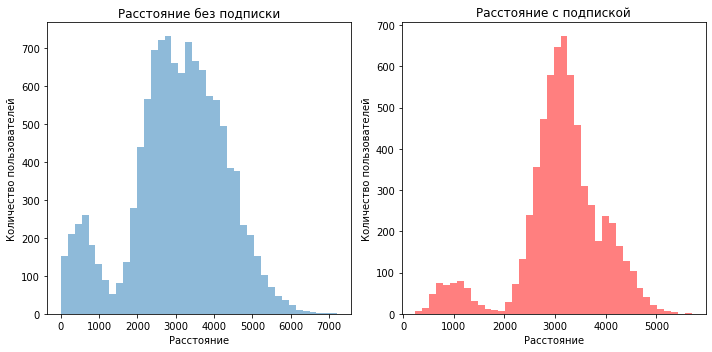

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

users_without_subscriptions['distance'].plot.hist(ax=ax1, bins=40, alpha=0.5)
users_with_subscriptions['distance'].plot.hist(ax=ax2, bins=40, alpha=0.5, color='red')
ax1.set_title('Расстояние без подписки')
ax1.set_xlabel('Расстояние')
ax1.set_ylabel('Количество пользователей')

ax2.set_title('Расстояние с подпиской')
ax2.set_xlabel('Расстояние')
ax2.set_ylabel('Количество пользователей')

fig.tight_layout()

plt.show()

In [47]:
users_with_subscriptions['duration'].agg(['mean', 'median','min','max'])

mean      18.541985
median    18.178153
min        3.760353
max       40.823963
Name: duration, dtype: float64

In [48]:
users_without_subscriptions['duration'].agg(['mean', 'median','min','max'])

mean      17.390909
median    17.326890
min        0.500000
max       34.948498
Name: duration, dtype: float64

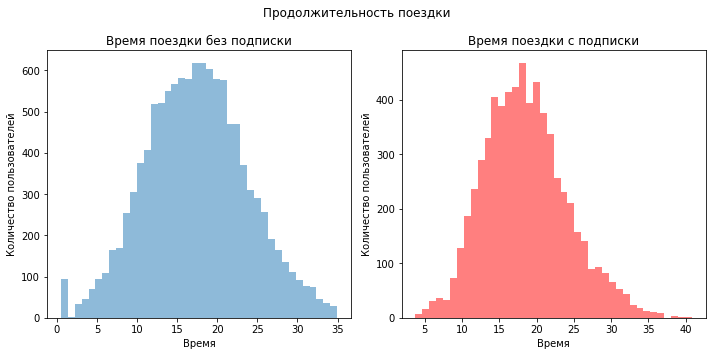

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Продолжительность поездки')

users_without_subscriptions['duration'].plot.hist(ax=ax[0], bins=40, alpha=0.5)
users_with_subscriptions['duration'].plot.hist(ax=ax[1], bins=40, alpha=0.5, color='red')

ax[0].set_title('Время поездки без подписки')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Количество пользователей')
ax[1].set_title('Время поездки с подписки')
ax[1].set_xlabel('Время')
ax[1].set_ylabel('Количество пользователей')

fig.tight_layout()
plt.show()

Максимальное расстояние у пользователей без подписки привосходит пользователей с подпиской на полтора километра. Среднее растояние у пользователей с и без подписки одинаковое. На гистограмме видно что присутствуют много пользователей без подписки которые проехали всего около 100 метров, возможно они не поняли как управлять самокатом.

По гистограммам можно сделать вывод, что:

**Для бесплатного тарифа** среднее время поездки составляет от 10 до 20 минут,растояние от 2 до 5 км

**Для тарифа с подпиской** в основном время в промежутке 15 до 25 минут. Пик расстояния приходится на 3км.

**Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи на платном тарифе.**

## Подсчёт выручки

In [50]:
table_users['duration'] = np.ceil(table_users['duration'])

In [51]:
total_data = pd.pivot_table(
    table_users,
    index=['month', 'user_id'],
    values=['distance', 'name', 'duration','subscription_type'],
    aggfunc={'distance': 'sum','name': 'count','duration':'sum', 'subscription_type': min}
)
total_data = total_data.rename(columns={'name': 'total_trips'})
total_data

distance  duration  total_trips subscription_type
month user_id                                                      
1     1        7027.511294      42.0            2             ultra
      3        3061.777147      13.0            1             ultra
      5        3914.646990      13.0            1             ultra
      7        6478.080979      28.0            2             ultra
      12       3577.151148      33.0            1             ultra
...                    ...       ...          ...               ...
12    1525     4597.854350      34.0            1              free
      1526     3644.121544      23.0            1              free
      1528     3998.569324      11.0            1              free
      1532     6111.889853      42.0            2              free
      1534     2371.711192      16.0            1              free

[11331 rows x 4 columns]

In [52]:
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['total_trips']
    else:
        return 'Not such sub'

In [53]:
total_data['revenue_per_month'] = total_data.apply(revenue, axis=1)

In [54]:
total_data

distance  duration  total_trips subscription_type  \
month user_id                                                         
1     1        7027.511294      42.0            2             ultra   
      3        3061.777147      13.0            1             ultra   
      5        3914.646990      13.0            1             ultra   
      7        6478.080979      28.0            2             ultra   
      12       3577.151148      33.0            1             ultra   
...                    ...       ...          ...               ...   
12    1525     4597.854350      34.0            1              free   
      1526     3644.121544      23.0            1              free   
      1528     3998.569324      11.0            1              free   
      1532     6111.889853      42.0            2              free   
      1534     2371.711192      16.0            1              free   

               revenue_per_month  
month user_id                     
1     1                    451.0  
      3                    277.0  
      5                    277.0  
      7                    367.0  
      12                   397.0  
...                          ...  
12    1525                 322.0  
      1526                 234.0  
      1528                 138.0  
      1532                 436.0  
      1534                 178.0  

[11331 rows x 5 columns]

In [55]:
total_data['revenue_per_month'].head(20)

month  user_id
1      1          451.0
       3          277.0
       5          277.0
       7          367.0
       12         397.0
       13         451.0
       14         409.0
       15         433.0
       20         373.0
       22         277.0
       25         301.0
       26         367.0
       30         349.0
       32         349.0
       35         541.0
       42         337.0
       43         487.0
       44         313.0
       45         361.0
       46         319.0
Name: revenue_per_month, dtype: float64

In [56]:
total_data.query('user_id == 1').agg({'revenue_per_month':['min','max']})

,revenue_per_month
min,241.0
max,535.0


In [57]:
total_data.query('user_id == 46').agg({'revenue_per_month':['min','max']})

,revenue_per_month
min,295.0
max,475.0


**Создали таблицу на показателях которых расчитали сумму выручки по месяцам. В зависимости от месяца суммы выручки по разным пользователям различаются**

## Проверка гипотез

Проверим некоторые гипотезы, чтобы сделать выводы как сделать бизнес лучше

**Гипотеза : Пользователи с подпиской тратят больше времени на поездки.**

**Ho** - пользователи с подпиской и без подписки тратят одинаковое время на поездки

**H1** - пользователи с подпиской тратят больше времени на поездки

Статистическую значимость возьмем за 5 процентов

In [58]:
from scipy import stats as st
ultra = users_with_subscriptions['duration'] 

free = users_without_subscriptions['duration']

results = st.ttest_ind(ultra, 
                       free,
                       alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Значит пользователи с подпиской тратят больше времени на поездки')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу. Значит пользователи с подпиской тратят больше времени на поездки


In [59]:
users_without_subscriptions['duration'].agg(['min','max', 'mean', 'median', 
                          lambda x: x.quantile(0.25), 
                          lambda x: x.quantile(0.50), 
                          lambda x: x.quantile(0.75)])

min          0.500000
max         34.948498
mean        17.390909
median      17.326890
<lambda>    12.958437
<lambda>    17.326890
<lambda>    21.594071
Name: duration, dtype: float64

In [60]:
users_with_subscriptions['duration'].agg(['min','max', 'mean', 'median', 
                          lambda x: x.quantile(0.25), 
                          lambda x: x.quantile(0.50), 
                          lambda x: x.quantile(0.75)])

min          3.760353
max         40.823963
mean        18.541985
median      18.178153
<lambda>    14.524654
<lambda>    18.178153
<lambda>    21.884129
Name: duration, dtype: float64

**Действительно пользователи с подпиской тратят больше времени на поездки.**
И имеют:

* минимальное время 3 минуты, а без подписки полторы минуты
* среднее время 18 минут, а без подписки 17 минут
* максимальное время 40 минут, а без подписки 34 минуты

**Гипотеза : Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 м.**

**Ho** - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку,равно 3130 м

**H1** - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 м

Статистическую значимость возьмем за 5 процентов

In [61]:
ultra_distance = users_with_subscriptions['distance'] 
                                   
interested_value = 3130                               
alpha = 0.05

results = st.ttest_1samp(ultra_distance, 
                         interested_value,
                         alternative='greater')

print(results.pvalue)  

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Значит среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 м')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


**Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи с подпиской  превышает 3130 метров.**

**Гипотеза : Помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки.**

**Ho** - помесячная выручка от пользователей с подпиской по месяцам будет равна  выручки от пользователей без подписки.

**H1** - помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки.

Статистическую значимость возьмем за 5 процентов

In [62]:
ultra_revenue_per_month = total_data.loc[total_data['subscription_type']=='ultra', 'revenue_per_month']
                                   
free_revenue_per_month =  total_data.loc[total_data['subscription_type']=='free', 'revenue_per_month']                              
alpha = 0.05



results = st.ttest_ind(ultra_revenue_per_month, 
                       free_revenue_per_month,
                       alternative = 'greater')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Значит помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки.')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу. Значит помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки.


**Гипотеза : Количество обращений в техподдержку значимо снизилось, так как техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение.**

**H0** - количество обращений в техподдержку после того как  техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение равно количеству обращений в техподдержку до.

**H1** - количество обращений в техподдержку значимо снизилось, так как техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение

К сожалению тест по проверки гипотез провести невозможно,  так как отсутствуют данные для рассчетов. Но если бы данные были в полном объеме то использовали бы scipy.stats.ttest_rel():парный t-тест - это статистический процедура, используемая для определения, есть ли значимая разница между средними значениями двух групп, в которых наблюдения в каждой группе связаны.

## Общий вывод

Для исследавания сервиса аренды самокатов GoFast, использовали таблицы, в которых есть информация о пользователях, их поездках и подписках.

**На этапе предобработки данных** выяснили, что пропущенных данных в таблицах нет. Дубликаты имеются среди пользователей и их 31, мы их удалили. В таблице с информацией о поездках и подписках дубликатов нет. Также мы приобразовали столбец с датой в таблице rides в тип даты и добавили в таблицу rides столбец month с номер месяца.

**На этапе исследования данных** обнаружили, что:

Пользоветели арендой самокатов распределены равномерно по всем городам

Пользователей, которые используют бесплатную подписку больше и их 835 человека. 54.4% пользователей без подписок и 45.6 с подпиской.

Возраст пользователей распределен от 12 до 43 лет. Наиболее активные пользователи от 20-30 лет.

Расстояние, которое пользователь преодолел за одну поездку: в среднем 3 км. Минимальное растояние - 0.86 км. Самая длинная - 7.2 км.

Продолжительность поездок: в среднем 17.68 минут. Минимальное время 50 секунд.Скорее всего или самокат был сломан или пользватель передумал пользоваться. Максимальное время поездки 40 минут.


**На этапе объединения данных** определили, что максимальное расстояние у пользователей без подписки привосходит пользователей с подпиской на полтора километра. Среднее растояние у пользователей с и без подписки одинаковое. Нарисовали гистограмму по которой видно что присутствуют много пользователей без подписки которые проехали всего около 100 метров, возможно они не поняли как управлять самокатом.

По гистограммам можно сделать вывод, что:

Для бесплатного тарифа среднее время поездки составляет от 10 до 20 минут,растояние от 2 до 5 км

Для тарифа с подпиской в основном время в промежутке 15 до 25 минут. Пик расстояния приходится на 3км.

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи на платном тарифе.

**На этапе подсчёта выручки** cоздали таблицу на показателях которых расчитали сумму выручки по месяцам. В зависимости от месяца суммы выручки по разным пользователям различаются

**На этапе проверки гипотез**

Отвергли 0 гипотезу и сделали вывод, что пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе

Не удалось отвергнуть нулевую гипотезу. Мы не можем утверждать, что расстояние, которое проехали пользователи с подпиской превышает 3130 метров.

Отвергли 0 гипотезу и сделали вывод, что помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

**Исходя из исследования важно увеличить количество пользователей с подпиской, чтобы увеличить выручку.**

